In [10]:
import json
import time

import flax
import flax.serialization
from luxai_s3.params import EnvParams
from luxai_s3.state import EnvState, serialize_env_actions, serialize_env_states
import jax
import jax.numpy as jnp

from luxai_s3.env import LuxAIS3Env

# from luxai_s3.wrappers import RecordEpisode

# Create the environment
env = LuxAIS3Env(auto_reset=False)
env_params = EnvParams(map_type=0, max_steps_in_match=50)

# Initialize a random key
key = jax.random.key(0)

# Reset the environment
key, reset_key = jax.random.split(key)
obs, state = env.reset(reset_key, params=env_params)
# Take a random action
key, subkey = jax.random.split(key)

env_params

EnvParams(max_steps_in_match=50, map_type=0, map_width=24, map_height=24, num_teams=2, match_count_per_episode=5, max_units=16, init_unit_energy=100, min_unit_energy=0, max_unit_energy=400, unit_move_cost=2, spawn_rate=5, unit_sap_cost=10, unit_sap_range=4, unit_sap_dropoff_factor=0.5, unit_energy_void_factor=0.125, max_energy_nodes=6, max_energy_per_tile=20, min_energy_per_tile=-20, max_relic_nodes=6, relic_config_size=5, fog_of_war=True, unit_sensor_range=2, nebula_tile_vision_reduction=1, nebula_tile_energy_reduction=0, nebula_tile_drift_speed=-0.05, energy_node_drift_speed=0.02, energy_node_drift_magnitude=5)

In [11]:
from argparse import Namespace
from dataclasses import dataclass
from typing import Any, Dict
import numpy as np
import networkx as nx
import numpy as np
from numpy.typing import ArrayLike, NDArray


def direction_to(src, target):
    ds = target - src
    dx = ds[0]
    dy = ds[1]
    if dx == 0 and dy == 0:
        return 0
    if abs(dx) > abs(dy):
        if dx > 0:
            return 2
        else:
            return 4
    else:
        if dy > 0:
            return 3
        else:
            return 1

In [12]:
def manhattan_distance(start_node: ArrayLike, end_node: ArrayLike) -> int:
    return abs(start_node[0] - end_node[0]) + abs(start_node[0] - end_node[0])

In [13]:
@dataclass(frozen=True)
class Coordinate:
    x: int
    y: int

    def __getitem__(self, index: int):
        if index == 0:
            return self.x
        elif index == 1:
            return self.y
        else:
            raise IndexError("Index out of range. Use 0 for 'x' and 1 for 'y'.")


class Graph:
    def __init__(self, map_width: int, map_height: int):
        self.map: nx.DiGraph = nx.grid_2d_graph(
            map_width, map_height, periodic=False, create_using=nx.DiGraph()
        )

In [102]:
G = Graph(24, 24)
obs_player_0 = obs["player_0"]

In [103]:
def update_nodes_from_obs(G: nx.DiGraph, obs: Dict[str, Any]):
    visible_tiles_indices = jax.numpy.indices(obs["sensor_mask"].shape)[
        :, obs["sensor_mask"]
    ]
    visible_energies = obs["map_features"]["energy"][obs["sensor_mask"]]
    visible_type_tiles = obs["map_features"]["tile_type"][obs["sensor_mask"]]
    for i in range(visible_tiles_indices.shape[1]):
        node_location = tuple(visible_tiles_indices[:, i].tolist())
        symmetric_node_location = tuple(np.array([23, 23]) - np.array(node_location))
        cost = visible_energies[i]
        G.add_node(node_location, energy=cost, type=visible_type_tiles[i])
        G.add_node(symmetric_node_location, energy=cost, type=visible_type_tiles[i])

    not_visible_tiles_indices = jax.numpy.indices(obs["sensor_mask"].shape)[
        :, ~obs["sensor_mask"]
    ]
    print(not_visible_tiles_indices.shape)
    for i in range(not_visible_tiles_indices.shape[1]):
        node_location = tuple(not_visible_tiles_indices[:, i].tolist())
        G.add_node(node_location, energy=0, type=-1)


update_nodes_from_obs(G.map, obs_to_dict(obs_player_0))

(2, 547)


In [104]:
G.map.nodes.data()

NodeDataView({(0, 0): {'energy': 0, 'type': -1}, (0, 1): {'energy': 0, 'type': -1}, (0, 2): {'energy': 0, 'type': -1}, (0, 3): {'energy': 0, 'type': -1}, (0, 4): {'energy': 0, 'type': -1}, (0, 5): {'energy': 0, 'type': -1}, (0, 6): {'energy': 0, 'type': -1}, (0, 7): {'energy': 0, 'type': -1}, (0, 8): {'energy': 0, 'type': -1}, (0, 9): {'energy': 0, 'type': -1}, (0, 10): {'energy': 0, 'type': -1}, (0, 11): {'energy': 0, 'type': -1}, (0, 12): {'energy': 0, 'type': -1}, (0, 13): {'energy': 0, 'type': -1}, (0, 14): {'energy': 0, 'type': -1}, (0, 15): {'energy': 0, 'type': -1}, (0, 16): {'energy': 0, 'type': -1}, (0, 17): {'energy': 0, 'type': -1}, (0, 18): {'energy': 0, 'type': -1}, (0, 19): {'energy': 0, 'type': -1}, (0, 20): {'energy': 0, 'type': -1}, (0, 21): {'energy': 0, 'type': -1}, (0, 22): {'energy': 0, 'type': -1}, (0, 23): {'energy': 0, 'type': -1}, (1, 0): {'energy': Array(7, dtype=int16), 'type': Array(0, dtype=int32, weak_type=True)}, (1, 1): {'energy': Array(2, dtype=int16), 

In [58]:
from networkx import neighbors


def remove_edges_from_asteroides(G: nx.DiGraph):
    neighbors_to_remove = []
    for n in G.nodes:
        if G.nodes[n].get("type", 0) == 2:
            for neighbor in G.neighbors(n):
                neighbors_to_remove.append((n, neighbor))

    G.remove_edges_from(neighbors_to_remove)


remove_edges_from_asteroides(G.map)

G.map.nodes.data()

NodeDataView({(0, 0): {'energy': 0, 'type': -1}, (0, 1): {'energy': 0, 'type': -1}, (0, 2): {'energy': 0, 'type': -1}, (0, 3): {'energy': 0, 'type': -1}, (0, 4): {'energy': 0, 'type': -1}, (0, 5): {'energy': 0, 'type': -1}, (0, 6): {'energy': 0, 'type': -1}, (0, 7): {'energy': 0, 'type': -1}, (0, 8): {'energy': 0, 'type': -1}, (0, 9): {'energy': 0, 'type': -1}, (0, 10): {'energy': 0, 'type': -1}, (0, 11): {'energy': 0, 'type': -1}, (0, 12): {'energy': 0, 'type': -1}, (0, 13): {'energy': 0, 'type': -1}, (0, 14): {'energy': 0, 'type': -1}, (0, 15): {'energy': 0, 'type': -1}, (0, 16): {'energy': 0, 'type': -1}, (0, 17): {'energy': 0, 'type': -1}, (0, 18): {'energy': 0, 'type': -1}, (0, 19): {'energy': 0, 'type': -1}, (0, 20): {'energy': 0, 'type': -1}, (0, 21): {'energy': 0, 'type': -1}, (0, 22): {'energy': 0, 'type': -1}, (0, 23): {'energy': 0, 'type': -1}, (1, 0): {'energy': 0, 'type': -1}, (1, 1): {'energy': 0, 'type': -1}, (1, 2): {'energy': 0, 'type': -1}, (1, 3): {'energy': 0, 'type

In [59]:
def update_edges_cost_from_energy_nodes(G: nx.DiGraph):
    for node_in, node_out in G.edges:
        # Get energy values of the two nodes
        energy_node_in = G.nodes[node_in].get("energy", 0)
        energy_node_out = G.nodes[node_out].get("energy", 0)

        # Calculate edge cost as |energy_u - energy_v| + 1000
        cost = energy_node_in - energy_node_out + 1000
        G.edges[node_in, node_out]["cost"] = cost


update_edges_cost_from_energy_nodes(G.map)

In [60]:
def get_closest_path(
    G: nx.DiGraph, start_node: ArrayLike, end_node: ArrayLike
) -> ArrayLike:
    return nx.astar_path(
        G, start_node, end_node, heuristic=manhattan_distance, weight="cost"
    )


list_nodes = get_closest_path(G.map, (0, 0), (16, 16))
direction_to(jnp.array(list_nodes[0]), jnp.array(list_nodes[1]))

2

In [61]:
class Agent:
    def __init__(self, player: str, env_cfg: Dict[str, Any]) -> None:
        np.random.seed(0)

        self.player = player
        self.opp_player = "player_1" if self.player == "player_0" else "player_0"
        self.team_id = 0 if self.player == "player_0" else 1
        self.opp_team_id = 1 if self.team_id == 0 else 0
        self.env_cfg = env_cfg

        self.graph = Graph(env_cfg["map_width"], env_cfg["map_height"])

        self.unit_explore_locations = dict()

    def act(self, step: int, obs: Dict[str, Any], remainingOverageTime: int = 60):
        """implement this function to decide what actions to send to each available unit.

        step is the current timestep number of the game starting from 0 going up to max_steps_in_match * match_count_per_episode - 1.
        """
        update_nodes_from_obs(self.graph.map, obs)
        remove_edges_from_asteroides(self.graph.map)
        update_edges_cost_from_energy_nodes(self.graph.map)

        unit_mask = np.array(obs["units_mask"][self.team_id])
        unit_positions = np.array(
            obs["units"]["position"][self.team_id]
        )  # shape (max_units, 2)
        available_unit_ids = np.where(unit_mask)[0]

        # Act randomly
        actions = np.zeros((self.env_cfg["max_units"], 3), dtype=int)

        for unit_id in available_unit_ids:
            unit_pos = unit_positions[unit_id]

            if (
                unit_id not in self.unit_explore_locations
                or np.sum(unit_pos - self.unit_explore_locations[unit_id]) == 0
            ):
                self.unit_explore_locations[unit_id] = (
                    np.random.randint(0, self.env_cfg["map_width"]),
                    np.random.randint(0, self.env_cfg["map_height"]),
                )

            print(tuple(unit_pos), self.unit_explore_locations[unit_id])
            list_nodes = get_closest_path(
                G.map, tuple(unit_pos), self.unit_explore_locations[unit_id]
            )

            actions[unit_id] = [
                direction_to(jnp.array(list_nodes[0]), jnp.array(list_nodes[1])),
                0,
                0,
            ]
        return actions

In [62]:
from luxai_s3.state import EnvObs


def env_params_to_dict(env_params: EnvParams) -> Dict[str, Any]:
    return {
        "map_width": env_params.map_width,
        "map_height": env_params.map_height,
        "max_steps_in_match": env_params.max_steps_in_match,
        "max_units": env_params.max_units,
    }


def obs_to_dict(obs: EnvObs) -> Dict[str, Any]:
    return {
        "units": {
            "position": obs.units.position,
            "energy": obs.units.energy,
        },
        "units_mask": obs.units_mask,
        "sensor_mask": obs.sensor_mask,
        "map_features": {
            "energy": obs.map_features.energy,
            "tile_type": obs.map_features.tile_type,
        },
        "relic_nodes": obs.relic_nodes,
        "relic_nodes_mask": obs.relic_nodes_mask,
        "team_points": obs.team_points,
        "team_wins": obs.team_wins,
        "steps": obs.steps,
        "match_steps": obs.match_steps,
    }


Agent("player_0", env_params_to_dict(env_params)).act(0, obs_to_dict(obs["player_0"]))

(np.int16(2), np.int16(0)) (12, 15)
(np.int16(2), np.int16(0)) (21, 0)
(np.int16(2), np.int16(0)) (3, 3)
(np.int16(2), np.int16(0)) (7, 9)
(np.int16(1), np.int16(0)) (19, 21)
(np.int16(1), np.int16(0)) (18, 4)
(np.int16(1), np.int16(0)) (23, 6)
(np.int16(1), np.int16(0)) (12, 1)
(np.int16(0), np.int16(0)) (6, 7)


array([[2, 0, 0],
       [2, 0, 0],
       [2, 0, 0],
       [2, 0, 0],
       [2, 0, 0],
       [2, 0, 0],
       [2, 0, 0],
       [2, 0, 0],
       [2, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0]])

In [63]:
from typing import OrderedDict


agent_0 = Agent("player_0", env_params_to_dict(env_params))
agent_1 = Agent("player_1", env_params_to_dict(env_params))

for _ in range(19):
    key, subkey = jax.random.split(key)
    action = OrderedDict(
        {
            "player_0": agent_0.act(0, obs_to_dict(obs["player_0"])),
            "player_1": agent_1.act(0, obs_to_dict(obs["player_1"])),
        }
    )
    obs, state, reward, terminated, truncated, info = env.step(
        subkey, state, action, params=env_params
    )

(np.int16(2), np.int16(0)) (12, 15)
(np.int16(2), np.int16(0)) (21, 0)
(np.int16(2), np.int16(0)) (3, 3)
(np.int16(2), np.int16(0)) (7, 9)
(np.int16(1), np.int16(0)) (19, 21)
(np.int16(1), np.int16(0)) (18, 4)
(np.int16(1), np.int16(0)) (23, 6)
(np.int16(1), np.int16(0)) (12, 1)
(np.int16(0), np.int16(0)) (6, 7)
(np.int16(18), np.int16(17)) (23, 14)
(np.int16(23), np.int16(22)) (17, 5)
(np.int16(18), np.int16(22)) (13, 8)
(np.int16(6), np.int16(15)) (9, 20)
(np.int16(23), np.int16(22)) (19, 16)
(np.int16(13), np.int16(18)) (19, 5)
(np.int16(19), np.int16(22)) (15, 15)
(np.int16(18), np.int16(23)) (0, 18)
(np.int16(23), np.int16(23)) (3, 17)
(np.int16(3), np.int16(0)) (12, 15)
(np.int16(3), np.int16(0)) (21, 0)
(np.int16(3), np.int16(0)) (3, 3)
(np.int16(3), np.int16(0)) (7, 9)
(np.int16(2), np.int16(0)) (19, 21)
(np.int16(2), np.int16(0)) (18, 4)
(np.int16(2), np.int16(0)) (23, 6)
(np.int16(2), np.int16(0)) (12, 1)
(np.int16(1), np.int16(0)) (6, 7)
(np.int16(19), np.int16(17)) (23, 14)

In [64]:
agent_0.graph.map.nodes(data=True)

NodeDataView({(0, 0): {'energy': 0, 'type': -1}, (0, 1): {'energy': 0, 'type': -1}, (0, 2): {'energy': 0, 'type': -1}, (0, 3): {'energy': 0, 'type': -1}, (0, 4): {'energy': 0, 'type': -1}, (0, 5): {'energy': 0, 'type': -1}, (0, 6): {'energy': 0, 'type': -1}, (0, 7): {'energy': 0, 'type': -1}, (0, 8): {'energy': 0, 'type': -1}, (0, 9): {'energy': 0, 'type': -1}, (0, 10): {'energy': 0, 'type': -1}, (0, 11): {'energy': 0, 'type': -1}, (0, 12): {'energy': 0, 'type': -1}, (0, 13): {'energy': 0, 'type': -1}, (0, 14): {'energy': 0, 'type': -1}, (0, 15): {'energy': 0, 'type': -1}, (0, 16): {'energy': 0, 'type': -1}, (0, 17): {'energy': 0, 'type': -1}, (0, 18): {'energy': 0, 'type': -1}, (0, 19): {'energy': 0, 'type': -1}, (0, 20): {'energy': 0, 'type': -1}, (0, 21): {'energy': 0, 'type': -1}, (0, 22): {'energy': 0, 'type': -1}, (0, 23): {'energy': 0, 'type': -1}, (1, 0): {'energy': 0, 'type': -1}, (1, 1): {'energy': 0, 'type': -1}, (1, 2): {'energy': 0, 'type': -1}, (1, 3): {'energy': 0, 'type

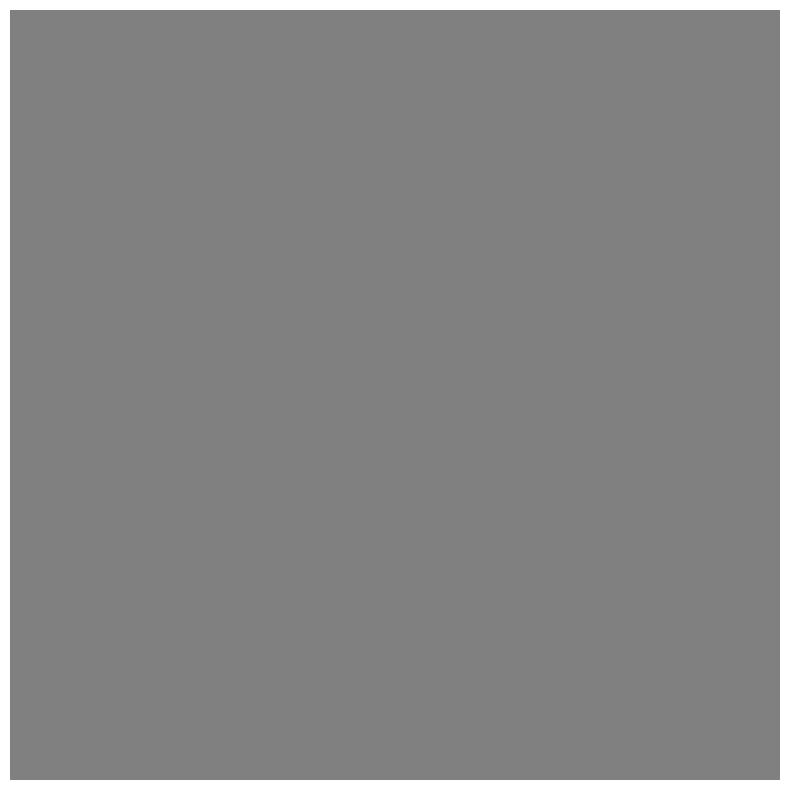

In [ ]:
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Créer une matrice vide
matrix = np.empty((24, 24), dtype=object)

# Remplir la matrice avec les types des cases
for (x, y), data in agent_0.graph.map.nodes(data=True):
    matrix[x, y] = data["type"]

# Conversion en DataFrame pour un affichage facile
df_map = pd.DataFrame(matrix)

# Définition des couleurs pour chaque type de case
color_map = {
    -1: (128, 128, 128),  # grey
    0: (0, 0, 255),  # blue
    1: (0, 128, 0),  # green
    2: (0, 100, 0),
}

# Convertir la matrice de types en une matrice RGB
color_matrix_rgb = np.array(
    [[color_map[val] for val in row] for row in df_map.values], dtype=np.uint8
)

# Afficher la carte
plt.figure(figsize=(10, 10))
plt.imshow(color_matrix_rgb)
plt.axis("off")
plt.show()

In [75]:
agent_0.graph.map.nodes(data=True)

NodeDataView({(0, 0): {'energy': 0, 'type': -1}, (0, 1): {'energy': 0, 'type': -1}, (0, 2): {'energy': 0, 'type': -1}, (0, 3): {'energy': 0, 'type': -1}, (0, 4): {'energy': 0, 'type': -1}, (0, 5): {'energy': 0, 'type': -1}, (0, 6): {'energy': 0, 'type': -1}, (0, 7): {'energy': 0, 'type': -1}, (0, 8): {'energy': 0, 'type': -1}, (0, 9): {'energy': 0, 'type': -1}, (0, 10): {'energy': 0, 'type': -1}, (0, 11): {'energy': 0, 'type': -1}, (0, 12): {'energy': 0, 'type': -1}, (0, 13): {'energy': 0, 'type': -1}, (0, 14): {'energy': 0, 'type': -1}, (0, 15): {'energy': 0, 'type': -1}, (0, 16): {'energy': 0, 'type': -1}, (0, 17): {'energy': 0, 'type': -1}, (0, 18): {'energy': 0, 'type': -1}, (0, 19): {'energy': 0, 'type': -1}, (0, 20): {'energy': 0, 'type': -1}, (0, 21): {'energy': 0, 'type': -1}, (0, 22): {'energy': 0, 'type': -1}, (0, 23): {'energy': 0, 'type': -1}, (1, 0): {'energy': 0, 'type': -1}, (1, 1): {'energy': 0, 'type': -1}, (1, 2): {'energy': 0, 'type': -1}, (1, 3): {'energy': 0, 'type